Evaluate SGM/SGM-AB for each ROI. 

I calculate the reg R between each col of SGM and empirical FCs.

# Import some pkgs

In [1]:
import sys
sys.path.append("./mypkg")

import scipy

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
# 
from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict
from collections import defaultdict as ddict
from IPython.display import display
%load_ext autoreload
%autoreload 2

In [2]:
# my own fns
from brain import Brain
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.misc import load_pkl, save_pkl
from utils.measures import reg_R_fn, lin_R_fn
plt.style.use(FIG_ROOT/"base.mplstyle")

# Some fns

In [3]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x));
_remove_norm = lambda x: x/np.linalg.norm(x)
_std_vec = lambda x: (x-np.mean(x))/np.std(x)
_remove_scale = _minmax_vec
uptri_idxs = np.triu_indices(68, k=1);
# transfer vec to a sym mat
def _vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

In [4]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr

def divide_fc(fc):
    """Divide the FC into three blocks and vectorize them
    """
    size_fc = len(fc)
    hs_fc = int(size_fc/2)
    fc_block1 = fc[:hs_fc, :hs_fc]
    fc_block2 = fc[hs_fc:, hs_fc:];
    fc_block3 = fc[:hs_fc, hs_fc:];
    vec1 = _remove_scale(fc_block1[np.triu_indices(hs_fc, k = 1)])
    vec2 = _remove_scale(fc_block2[np.triu_indices(hs_fc, k = 1)])
    vec3 = _remove_scale(fc_block3.flatten())
    return vec1, vec2, vec3

def cal_metrics(fc1, fc2):
    """Calculate the roiwise reg r between two FCs
    """
    fc1 = fc1.astype(np.float64)
    fc2 = fc2.astype(np.float64)
    
    reg_r_rw = reg_R_fn(fc1, fc2)
    
    return reg_r_rw

def cal_metrics_batch(fc1s, fc2s):
    """fc1s, fc2s: num_fc x 68 x 68
    """
    ress = []
    for ix in range(len(fc1s)):
        fc_t = fc2s[ix]
        fc_e = fc1s[ix]
        res = cal_metrics(fc_t, fc_e)
        ress.append(res)
    
    return np.array(ress)

In [5]:
# for spin test
from sphere_utils import generate_spins, get_mid_pts, trans_spins
import nibabel as nib

# load data 
# left
surface = nib.freesurfer.read_geometry(DATA_ROOT/'fs_data/lh.pial')
sphere = nib.freesurfer.read_geometry(DATA_ROOT/'fs_data/lh.sphere')
lh_vers= surface[0]  
lh_faces = surface[1];  
lh_vers_sph = sphere[0];
lh_labs = nib.freesurfer.read_annot(DATA_ROOT/'fs_data/lh.aparc.annot');

# right 
surface = nib.freesurfer.read_geometry(DATA_ROOT/'fs_data/rh.pial')
sphere = nib.freesurfer.read_geometry(DATA_ROOT/'fs_data/rh.sphere')
rh_vers= surface[0]  
rh_faces = surface[1];  
rh_vers_sph = sphere[0];
rh_labs = nib.freesurfer.read_annot(DATA_ROOT/'fs_data/rh.aparc.annot');


# the order of my ROI
my_roi_labs = np.loadtxt(DATA_ROOT/"rois_order.txt", dtype=str);

lh_my_labs = np.array([ix.split("_L")[0].lower() for ix in my_roi_labs[:34]]);
lh_sph_labs = np.array([ix.decode('ascii') for ix in lh_labs[-1]]);
rh_my_labs = np.array([ix.split("_R")[0].lower() for ix in my_roi_labs[34:68]]);
rh_sph_labs = np.array([ix.decode('ascii') for ix in rh_labs[-1]]);


rh_mid_pts = get_mid_pts(rh_vers_sph, rh_labs[0]);
lh_mid_pts = get_mid_pts(lh_vers_sph, lh_labs[0]);


spins_raw = generate_spins(points_lh=lh_mid_pts, 
                       points_rh=rh_mid_pts, 
                       unique=True, 
                       n_rep=1000);

spins_lh = trans_spins(spins_raw["lh"], lh_sph_labs, lh_my_labs);
spins_rh = trans_spins(spins_raw["rh"], rh_sph_labs, rh_my_labs);
spins = np.concatenate([spins_lh, spins_rh+34], axis=-1);
spins = spins.astype(int);

In [6]:
def _get_base_metrics(fc, spins):
    """Get baseline mse via spin test
    """
    num_rep = len(spins)
    
    regrs = []
    for ix in range(num_rep):
        spin_idxs = spins[ix]
        fc_spin = fc.copy()[spin_idxs][:, spin_idxs]
        regr_rw = cal_metrics(fc, fc_spin)
        regrs.append(regr_rw)
    regrs = np.array(regrs)
    metric = [np.mean(regrs, axis=0), np.std(regrs, axis=0)]
    return metric

# Load data and params

In [7]:
paras = edict()
paras.allbds = ["delta", "theta", "alpha", "beta_l"]
paras.add_v = 0.01
paras.nepoch = 100

paras.delta = [2, 3.5]
paras.theta = [4, 7]
paras.alpha = [8, 12]
paras.beta_l = [13, 20]

In [9]:
# em FC
fc_root = RES_ROOT/"emp_fcs2"
def _get_fc(sub_ix, bd):
    fil = list(fc_root.rglob(f"*{bd}*{paras.nepoch}/sub{sub_ix}.pkl"))[0]
    return np.abs(load_pkl(fil, verbose=False))

In [11]:
# get the base metrics
base_metric_means = edict()
base_metric_stds = edict()
for band in paras.allbds:
    empfcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);
    
    base_metrics = np.array([_get_base_metrics(fc, spins) for fc in empfcs]);
    base_metric_means[band] = base_metrics[:, 0]
    base_metric_stds[band] = base_metrics[:, 1];

In [12]:

def _add_v2con(cur_ind_conn, add_v):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.quantile(cur_ind_conn, 0.99)*add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn


In [13]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values;
#scs = ind_conn.transpose(2, 0, 1)[:, :68, :68];
#scs = np.array([_preprocess_sc(sc) for sc in scs]);

scs = []
for cur_ind_idx in range(36):
    # create spectrome brain:
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
     # re-assign connectome to individual connectome
    brain.connectome =  _add_v2con(ind_conn[:, :, cur_ind_idx], paras.add_v)
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    sc = brain.reducedConnectome
    scs.append(sc[:68, :68])
scs = np.array(scs)
scs.shape

(36, 68, 68)

# calculate reg R

In [14]:
method_names = [
                "SGM-SBI", 
                "SGM-SBI-shared", 
                #"Direct", 
                ]
band_res = edict()
for band in paras.allbds:
    sbi_ann_res = load_pkl(RES_ROOT/(f"rawfc2_SBIxANNBW_{band}_"
                                     f"ep{paras.nepoch}_"
                                     f"num1000_densitynsf_MR3_noise_sd120_"
                                     f"addv{paras.add_v*100:.0f}"
                                     f"/inf_res.pkl"), verbose=False);
    sbi_ann_ab_res = load_pkl(RES_ROOT/(f"rawfc2allbd_SBIxANNALLBD_"
                                        f"{'-'.join(paras.allbds)}_"
                                        f"ep{paras.nepoch}_"
                                        f"num1000_densitynsf_MR3_noise_sd120_"
                                        f"addv{paras.add_v*100:.0f}"
                                        f"/inf_res.pkl"), verbose=False);
    
    fcss = edict()
    fcss["SGM-SBI"] = np.array([np.abs(est_FC) for est_FC in sbi_ann_res.est_FCs]);
    fcss["SGM-SBI-shared"]= np.array([np.abs(est_FC) for est_FC in sbi_ann_ab_res[f"est_FCs_{band}"]])
    fcss["Direct"] = scs
    empfcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);

    base_metrics = np.array([_get_base_metrics(fc, spins) for fc in empfcs]);
    base_metric_mean = base_metrics[:, 0]
    base_metric_std = base_metrics[:, 1];print(base_metric_mean.shape)
    
    ress = edict()
    ress_full = edict()
    for key in method_names:
        cur_res =  cal_metrics_batch(fcss[key], empfcs);
        ress_full[key] = cur_res
        ress[key] = cur_res.mean(axis=0)
        ress[key+"_std"] = cur_res.std(axis=0)
    
    out_df = pd.DataFrame(ress)
    print(f"Results of {band}")
    display(out_df)
    band_res[band] = ress_full

(36, 68)
Results of delta


SGM-SBI  SGM-SBI_std  SGM-SBI-shared  SGM-SBI-shared_std
0   0.470751     0.163608        0.450333            0.160954
1   0.301996     0.143321        0.305140            0.132606
2   0.442953     0.166819        0.440820            0.154449
3   0.638964     0.091229        0.649400            0.082097
4   0.481263     0.195266        0.478482            0.187857
..       ...          ...             ...                 ...
63  0.536590     0.102704        0.534924            0.098487
64  0.407566     0.257631        0.409883            0.250455
65  0.519848     0.140041        0.533187            0.131867
66  0.525954     0.119135        0.487493            0.120299
67  0.491577     0.147488        0.486491            0.148037

[68 rows x 4 columns]

(36, 68)
Results of theta


SGM-SBI  SGM-SBI_std  SGM-SBI-shared  SGM-SBI-shared_std
0   0.473556     0.149061        0.455448            0.151898
1   0.292167     0.158902        0.286346            0.151226
2   0.449910     0.139322        0.446931            0.135415
3   0.665882     0.095096        0.664788            0.091869
4   0.464434     0.180935        0.459330            0.176862
..       ...          ...             ...                 ...
63  0.531326     0.129294        0.530858            0.126654
64  0.439137     0.242791        0.433799            0.233982
65  0.501529     0.161233        0.512142            0.154621
66  0.495797     0.115481        0.460482            0.114078
67  0.466794     0.184023        0.469545            0.183128

[68 rows x 4 columns]

(36, 68)
Results of alpha


SGM-SBI  SGM-SBI_std  SGM-SBI-shared  SGM-SBI-shared_std
0   0.422899     0.136902        0.432344            0.138815
1   0.246065     0.141574        0.242296            0.125903
2   0.435693     0.111642        0.441471            0.113223
3   0.576417     0.100236        0.601025            0.089236
4   0.393236     0.175429        0.404369            0.176646
..       ...          ...             ...                 ...
63  0.492950     0.118205        0.508504            0.117131
64  0.376842     0.203243        0.399891            0.210457
65  0.462117     0.148171        0.483215            0.144071
66  0.375801     0.161131        0.383672            0.144202
67  0.460704     0.172399        0.464030            0.168308

[68 rows x 4 columns]

(36, 68)
Results of beta_l


SGM-SBI  SGM-SBI_std  SGM-SBI-shared  SGM-SBI-shared_std
0   0.345707     0.129373        0.300440            0.128254
1   0.181911     0.114966        0.122291            0.139794
2   0.342705     0.096577        0.309263            0.120195
3   0.402309     0.089995        0.374802            0.096137
4   0.298002     0.160437        0.277222            0.145849
..       ...          ...             ...                 ...
63  0.305566     0.105763        0.308888            0.113726
64  0.294139     0.151404        0.226666            0.120485
65  0.334014     0.105160        0.282004            0.115793
66  0.319338     0.136004        0.252046            0.138160
67  0.381950     0.114061        0.302847            0.155346

[68 rows x 4 columns]

### Brain plot


In [15]:
org_ord = np.loadtxt(DATA_ROOT/"rois_order.txt", dtype=str)
org_ord = np.array([".".join([roi.split("_")[1].lower(), roi.split("_")[0].lower()]) for roi in org_ord][:68])
target_ord = np.loadtxt(DATA_ROOT/"dk68_utils/ROI_order_DK68.txt", dtype=str);
order_idxs = np.where(target_ord.reshape(-1, 1)== org_ord.reshape(1, -1))[-1];
# if a vec is from org_ord, then vec[order_idxs] is with target_ord

In [16]:
from nilearn import plotting
from utils.brain_plot import get_bg_data
import matplotlib as mpl
def _brain_plot(vec, cmap="Reds", threshold=None, vbds=None):
    root = DATA_ROOT/"dk68_utils/"
    h = 0.6
    
    XYZsl = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_XYZs_left.txt")
    facesl = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_faces_left.txt").astype(np.int64)
    roi_tmpl = np.loadtxt(root/"brain_tmp_left_DK68.txt");
    bg_datal = get_bg_data(XYZsl, facesl)
    
    XYZsr = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_XYZs_right.txt")
    facesr = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_faces_right.txt").astype(np.int64)
    roi_tmpr = np.loadtxt(root/"brain_tmp_right_DK68.txt");
    bg_datar = get_bg_data(XYZsr, facesr)
    
    # map vec to the template
    vecl = roi_tmpl.copy()
    vecr = roi_tmpr.copy()
    for roi_ix in range(1, 35):
        vecl[roi_tmpl==roi_ix] = vec[roi_ix-1]
        vecr[roi_tmpr==roi_ix] = vec[roi_ix-1+34]
        
    if vbds is None:
        vmin, vmax = np.min(vec), np.max(vec)
    else:
        vmin, vmax = vbds
    #fig, axs = plt.subplots(2, 2, figsize=[10, 10], subplot_kw={'projection': '3d'})
    fig = plt.figure(figsize=(10, 6))
    # left, bottom, width, height
    # facecolor make the bg  transparent
    ax1 = fig.add_axes([0.1,  0.5, h,  h], projection='3d',  facecolor='none')
    ax2 = fig.add_axes([0.15, 0.1, h,  h], projection='3d',  facecolor='none') 
    ax3 = fig.add_axes([0.5,  0.5, h,  h], projection='3d',  facecolor='none')
    ax4 = fig.add_axes([0.47, 0.1, h,  h], projection='3d',  facecolor='none')  
    
    plotting.plot_surf_roi([XYZsl, facesl], vecl, hemi='left', view="lateral", axes=ax1, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datal, # TO get the depth of the brain plot
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsl, facesl], vecl, hemi='left', view="medial", axes=ax2, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datal,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsr, facesr], vecr, hemi='right', view="lateral", axes=ax3, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datar,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsr, facesr], vecr, hemi='right', view="medial", axes=ax4, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datar,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    
    #fig.text(0.22, 0.36, 'Medial', ha='center', va='center')
    #fig.text(0.22, 0.78, 'Lateral', ha='center', va='center')
    #fig.text(0.24, 0.97, 'Left', ha='center', va='center')
    #fig.text(0.92, 0.97, 'Right', ha='center', va='center')
    #plt.suptitle("-log pvalues", fontsize=30)
    
    #norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    #sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    #sm.set_array([])  
    #cbar_ax = fig.add_axes([.91, .3, .03, .4])
    #fig.colorbar(sm, cax=cbar_ax)
    return fig

#### Plot mean and std

In [12]:
# get the min and max of the FCs to set the colorbar
pool_vs = []
pool_vs_std = []
for band in paras.allbds:
    for meth in method_names:
        pool_vs.append(band_res[band][meth].mean(axis=0))
        pool_vs_std.append(band_res[band][meth].std(axis=0))
pool_vs = np.array(pool_vs); 
pool_vs_std = np.array(pool_vs_std)
print(pool_vs.min(), pool_vs.max())
print(pool_vs_std.min(), pool_vs_std.max())
vmin, vmax = 0.1, 0.7
vmin_std, vmax_std = 0.05, 0.3

0.12229127279453679 0.6658823461505321
0.07260613729166439 0.25763131429190245


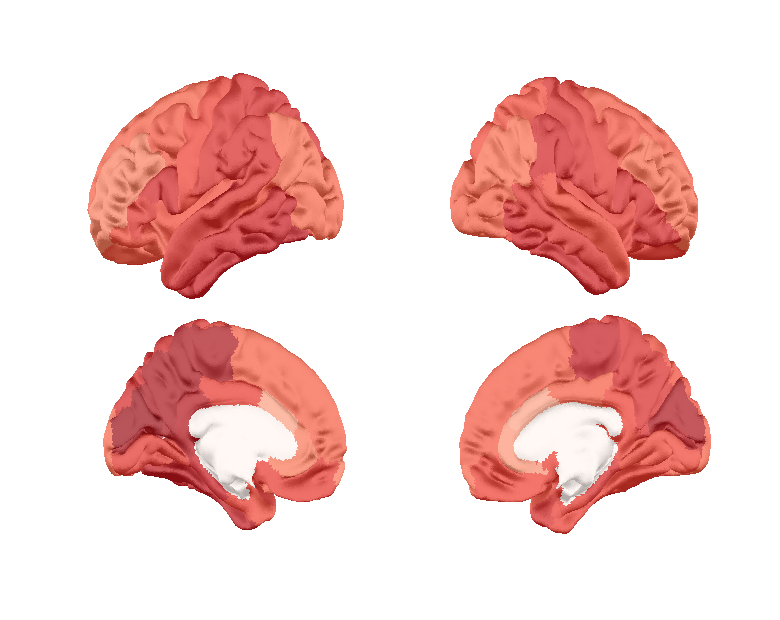

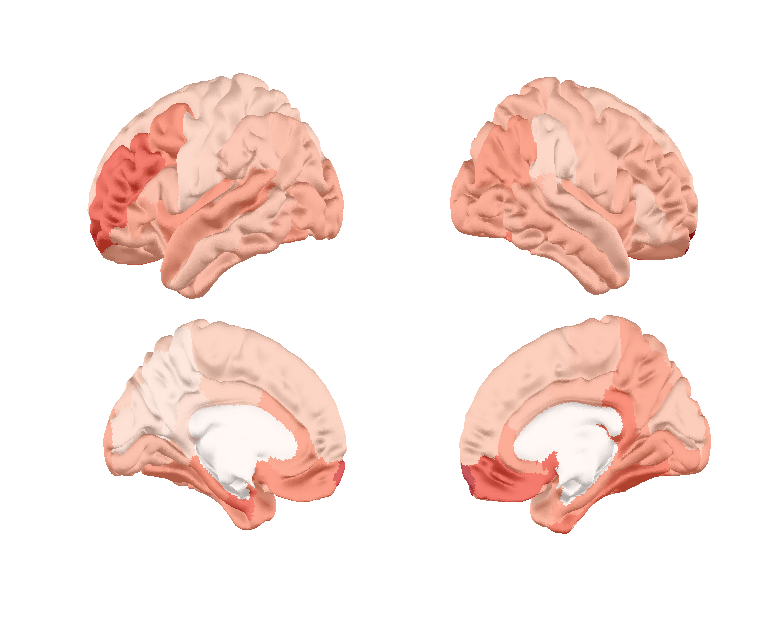

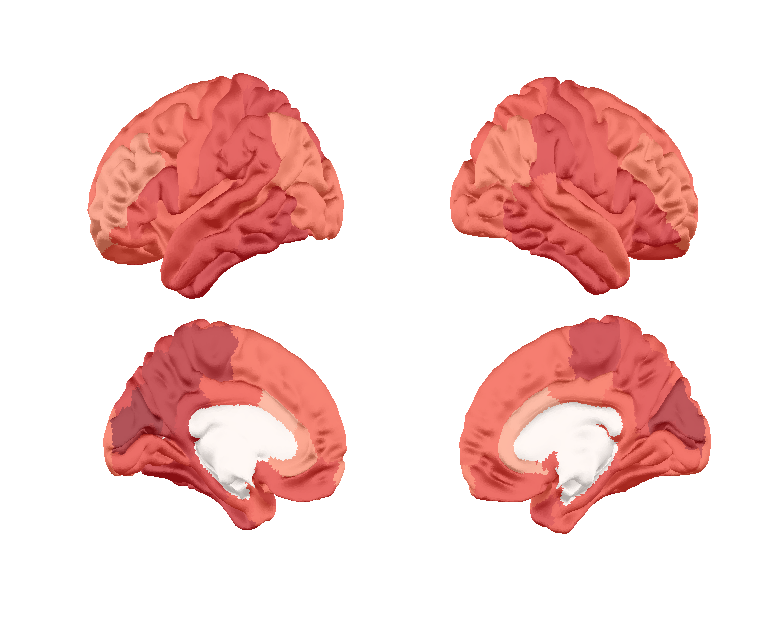

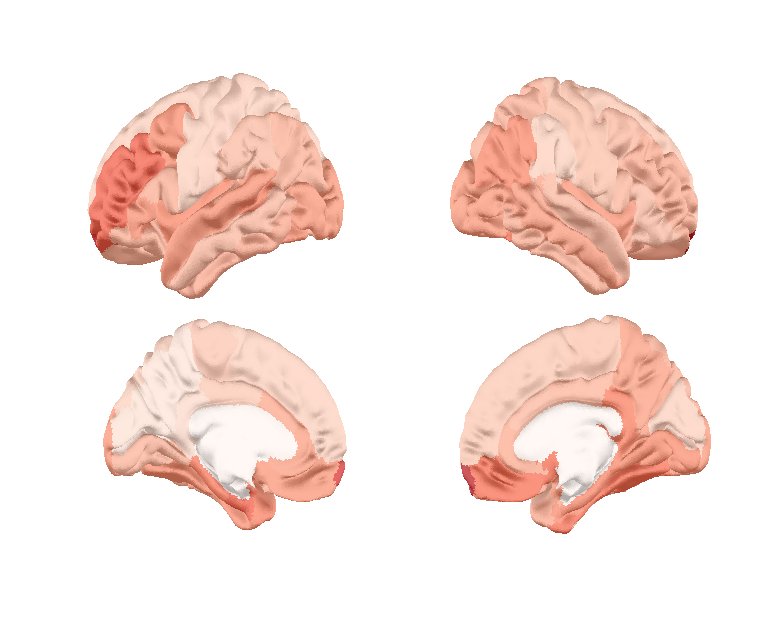

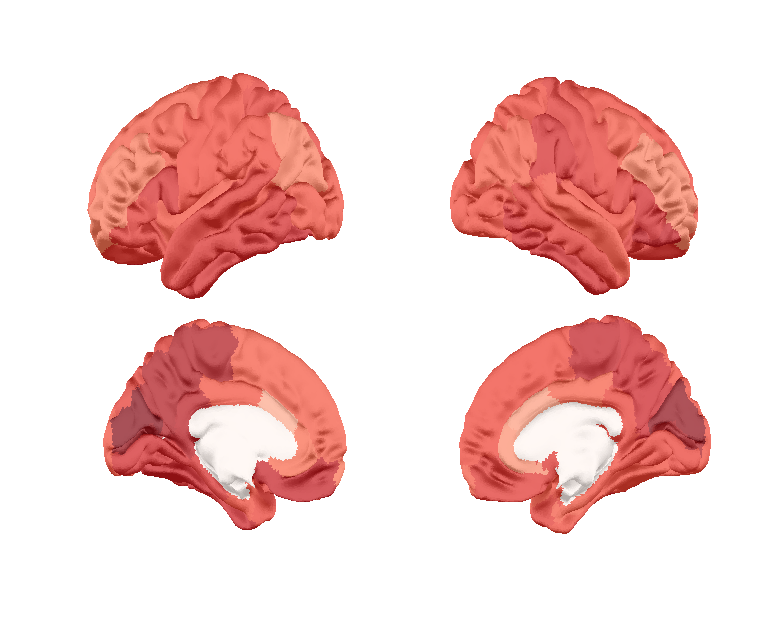

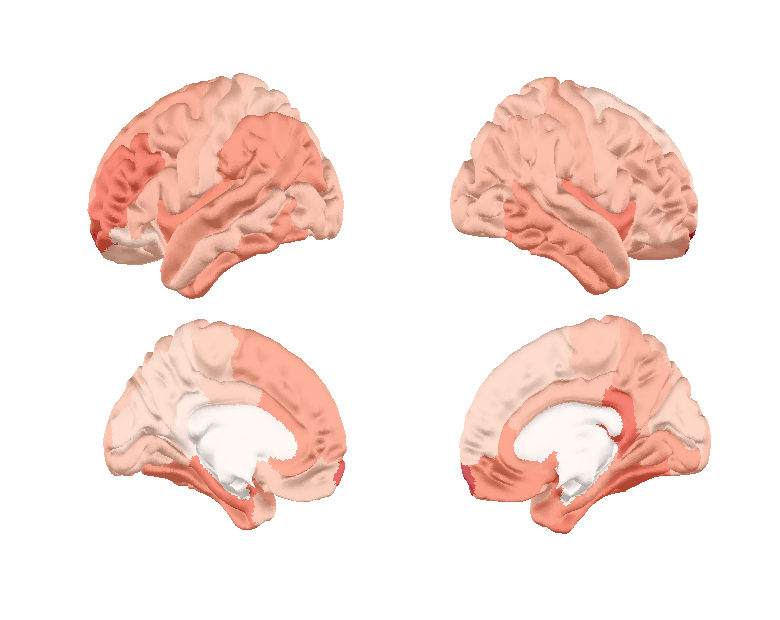

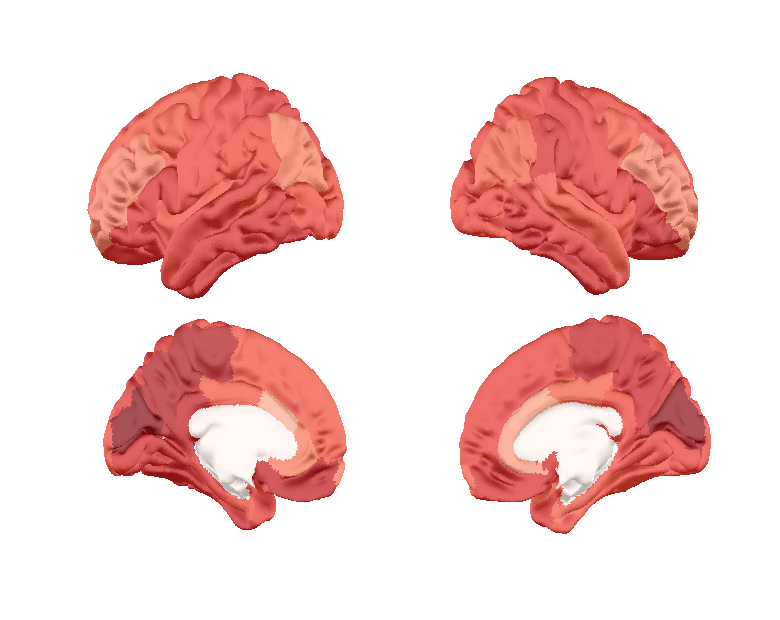

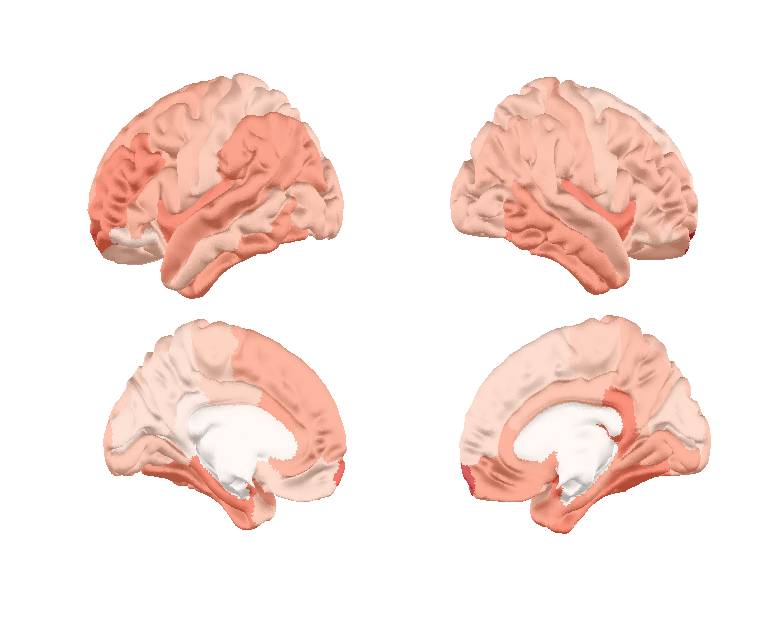

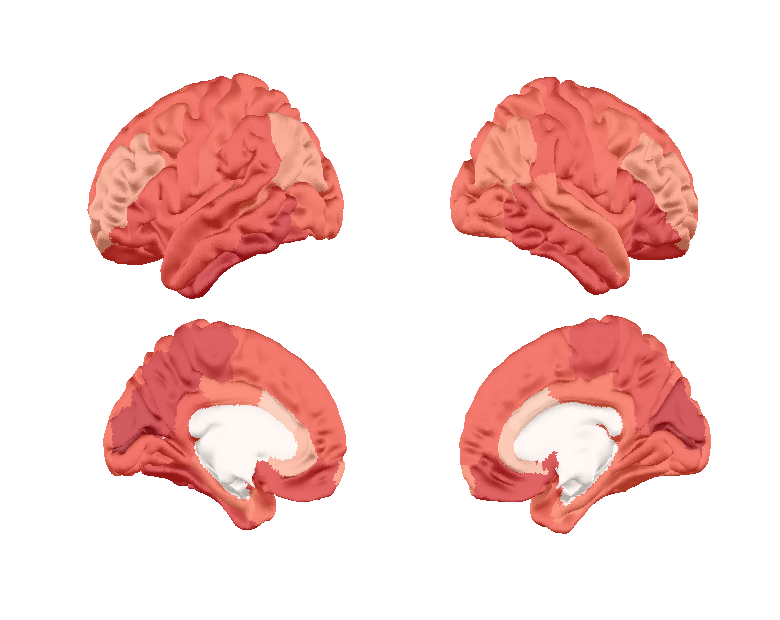

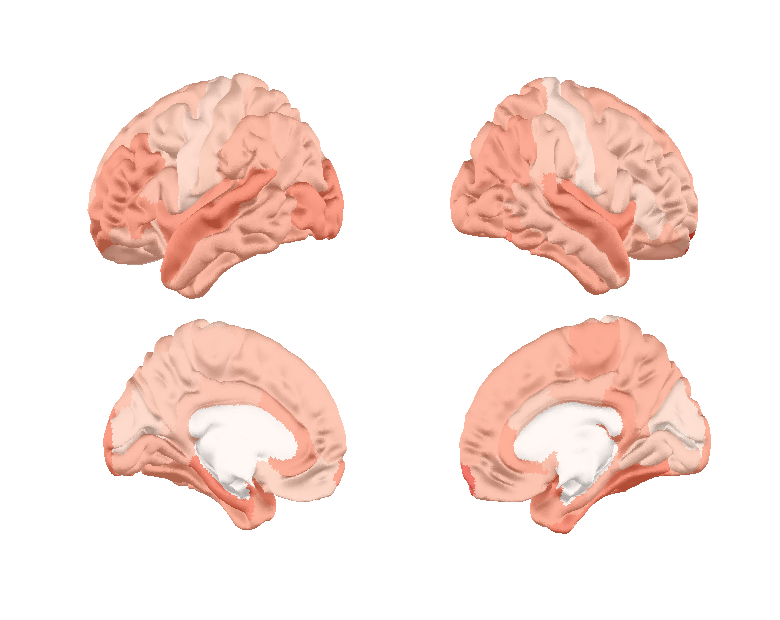

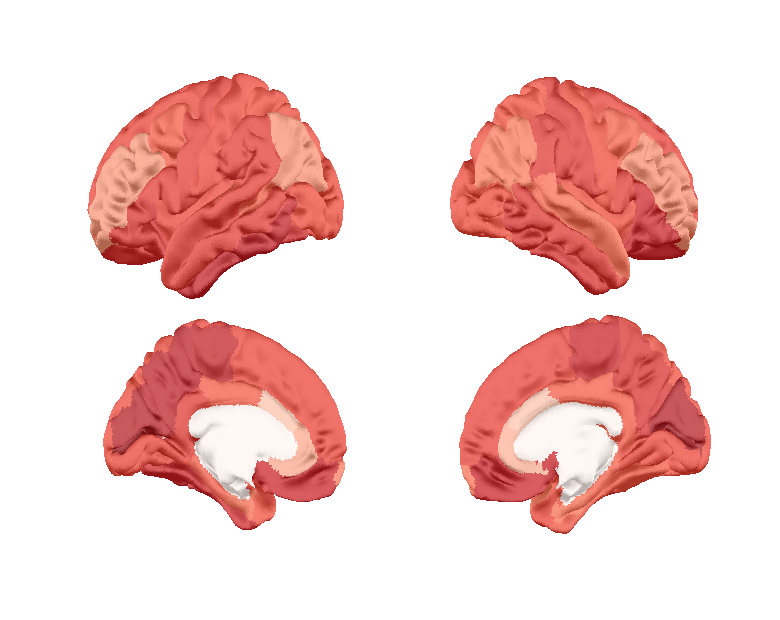

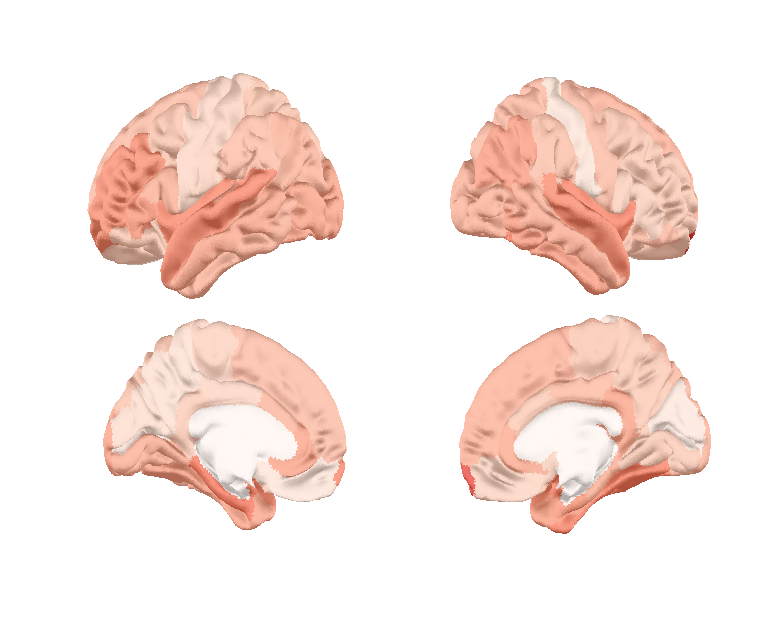

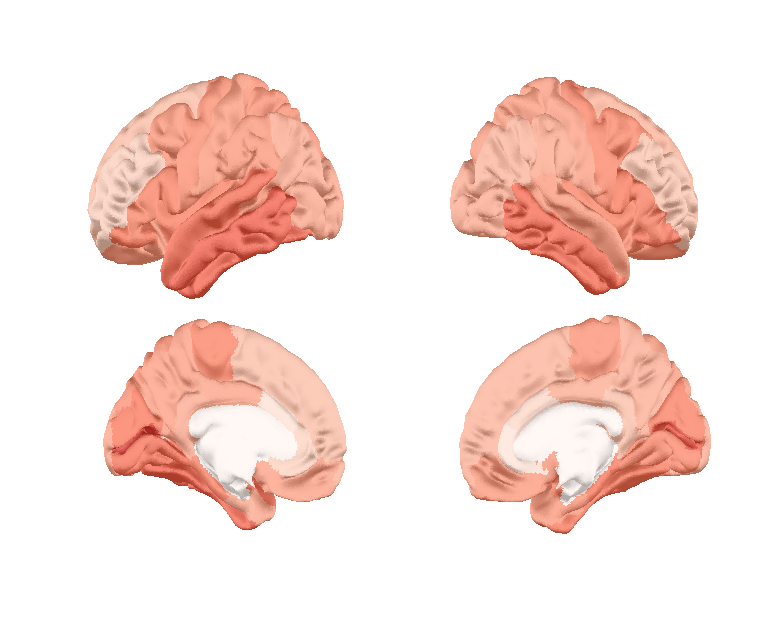

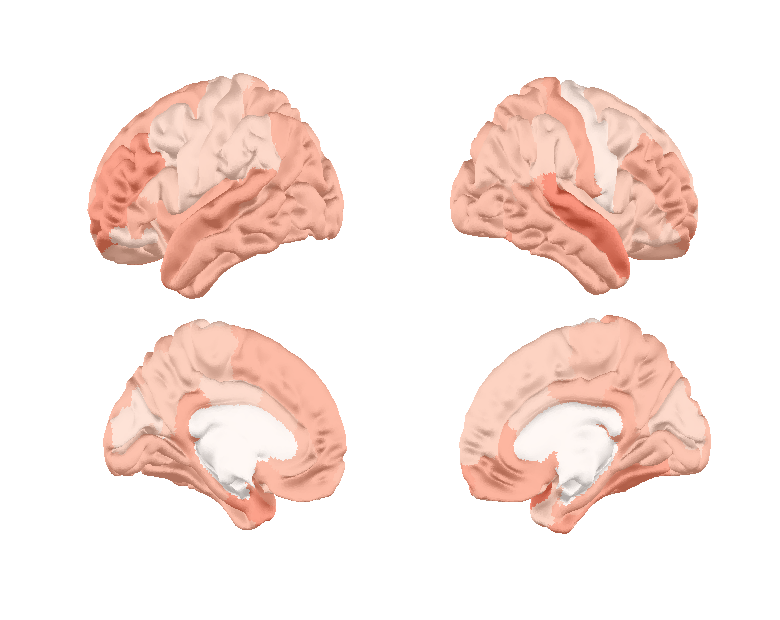

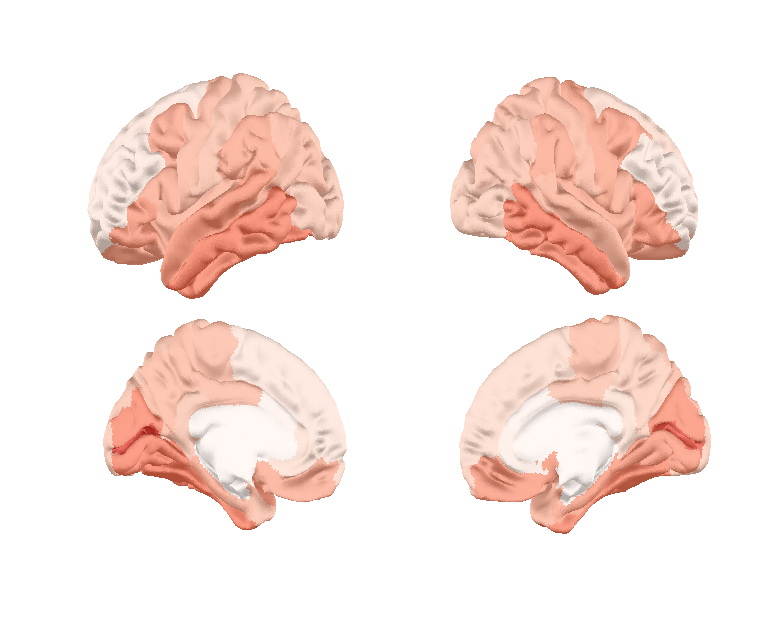

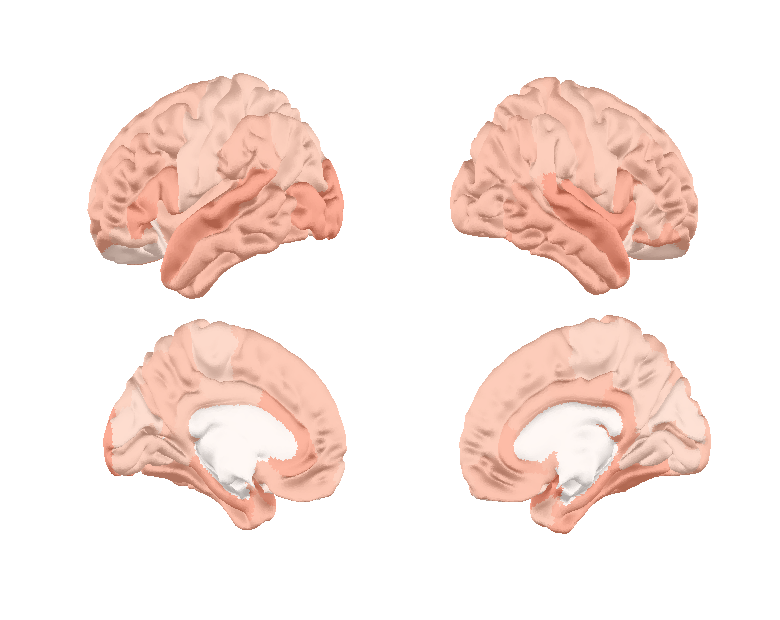

In [13]:
cmap = "Reds"

for band in paras.allbds:
    for meth in method_names: 
        vec = band_res[band][meth].mean(axis=0)
        vec_std = band_res[band][meth].std(axis=0)
        fig = _brain_plot(vec[order_idxs], cmap=cmap, vbds=[vmin, vmax]);
        fig.savefig(FIG_ROOT/f"revisionR1/rowwise_regr_{band}_{meth}_mean.jpg")
        fig = _brain_plot(vec_std[order_idxs], cmap=cmap, vbds=[vmin_std, vmax_std]);
        fig.savefig(FIG_ROOT/f"revisionR1/rowwise_regr_{band}_{meth}_std.jpg")

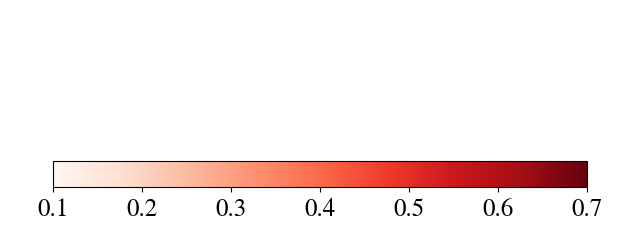

In [14]:
import matplotlib as mpl
cmap = "Reds"

fig, ax = plt.subplots(figsize=(8, 2))
plt.subplots_adjust(top=1)

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
ax.axis('off')

plt.savefig(FIG_ROOT/f"revisionR1/brain_metric_{cmap}_colorbar.jpg")

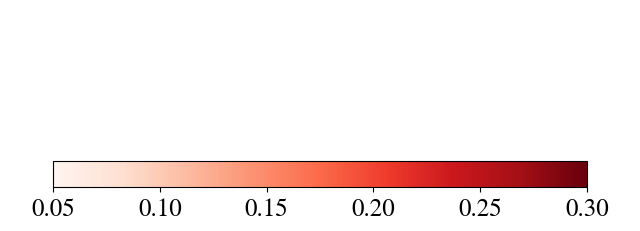

In [15]:
import matplotlib as mpl
cmap = "Reds"

fig, ax = plt.subplots(figsize=(8, 2))
plt.subplots_adjust(top=1)

norm = mpl.colors.Normalize(vmin=vmin_std, vmax=vmax_std)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
ax.axis('off')

plt.savefig(FIG_ROOT/f"revisionR1/brain_metric_{cmap}_colorbar_std.jpg")

#### Plot negative log pvalues

Here I use t test to test if the reg R is significantly different from 0 
and the reg R is standardized with spin test.

In [17]:
from scipy.stats import ttest_1samp
band = "alpha"
method = "SGM-SBI"
pool_pvals = []
band_res_pval = edict()
for band in paras.allbds:
    band_res_pval[band] = edict()
    for method in method_names:
        #metric = band_res[band][method] 
        metric = (band_res[band][method] - base_metric_means[band])/base_metric_stds[band]
        pvals = []
        for roi_ix in range(68):
            vec = metric[:, roi_ix]
            pval = ttest_1samp(vec, 0).pvalue
            pvals.append(pval)  
        pvals = np.array(pvals);
        band_res_pval[band][method] = pvals
        pool_pvals.append(pvals)
pool_pvals = np.array(pool_pvals);
nlogpvals = -np.log(pool_pvals)
cutv = 0.05/68;
vmin = -np.log(cutv) 
vmax = nlogpvals.max()
(vmin, vmax)

(7.215239978730097, 73.7971322027153)

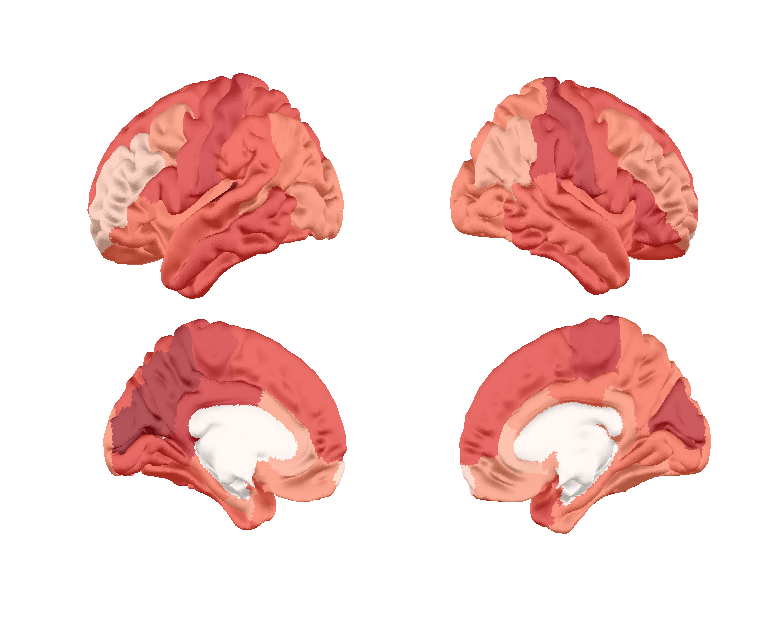

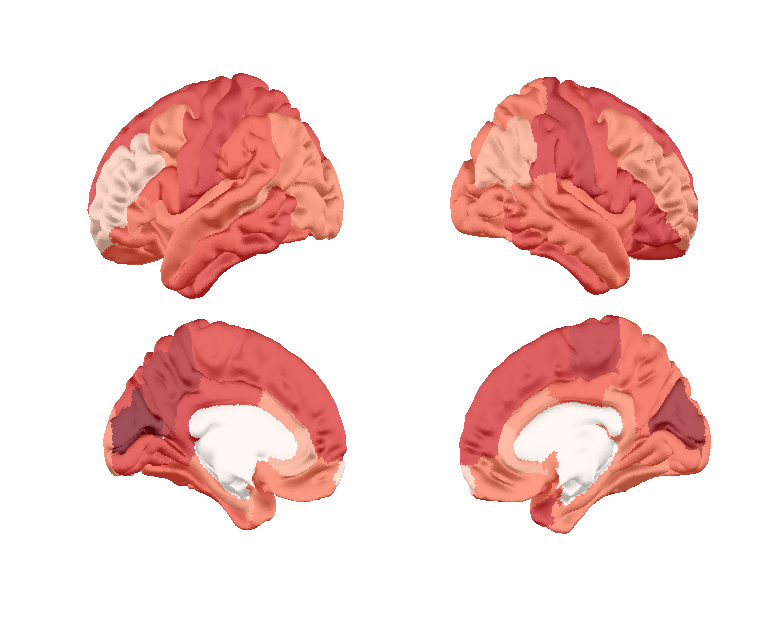

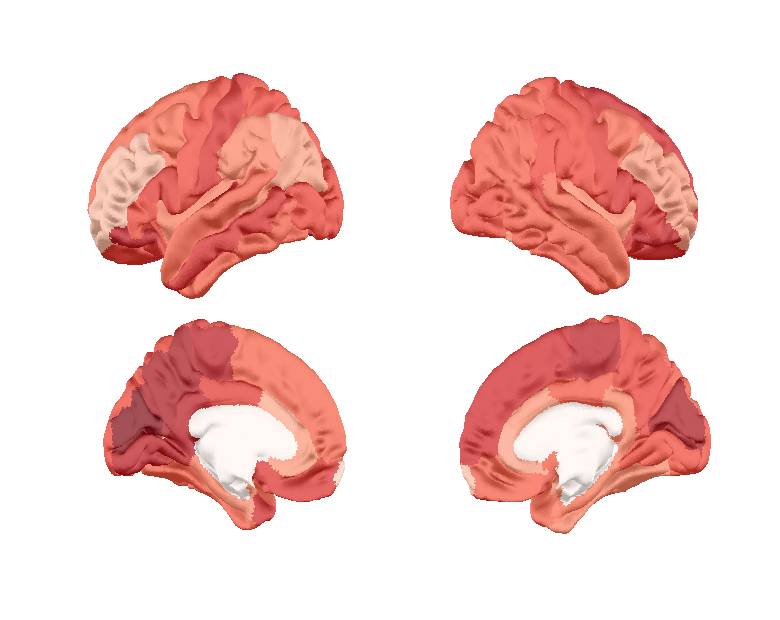

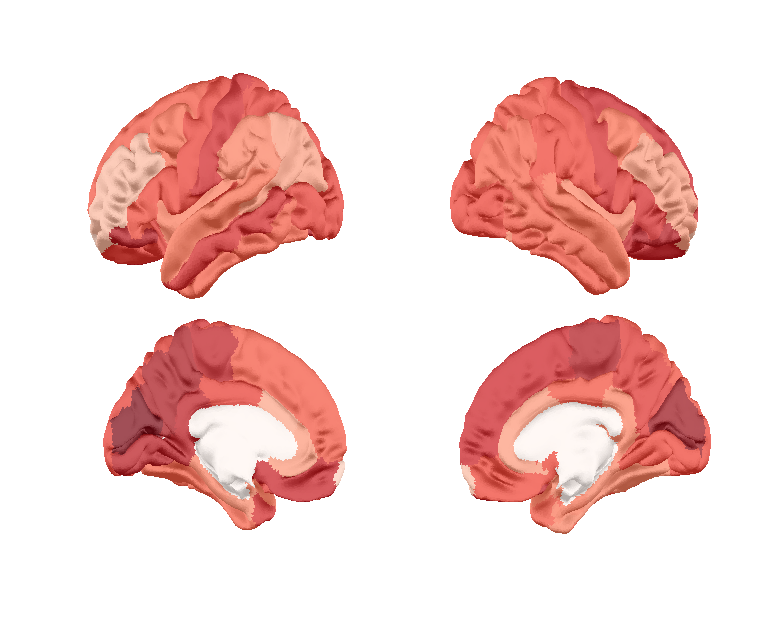

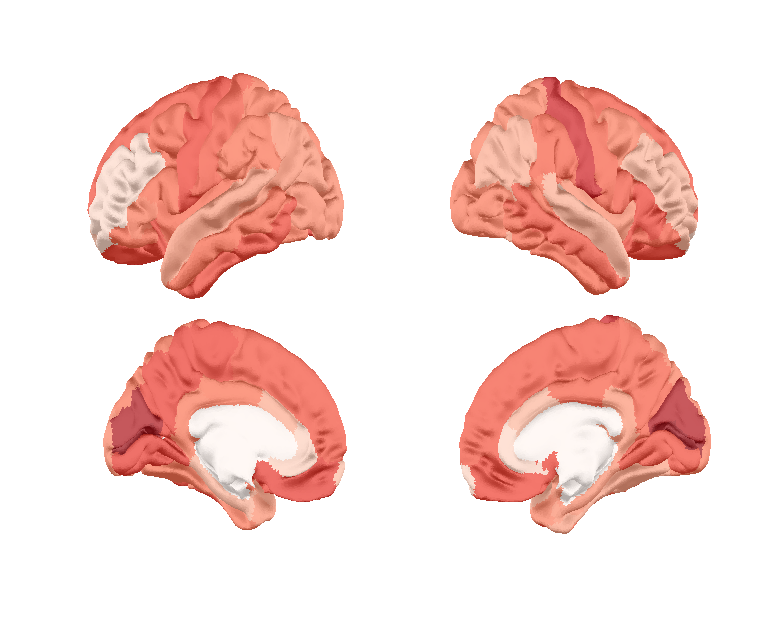

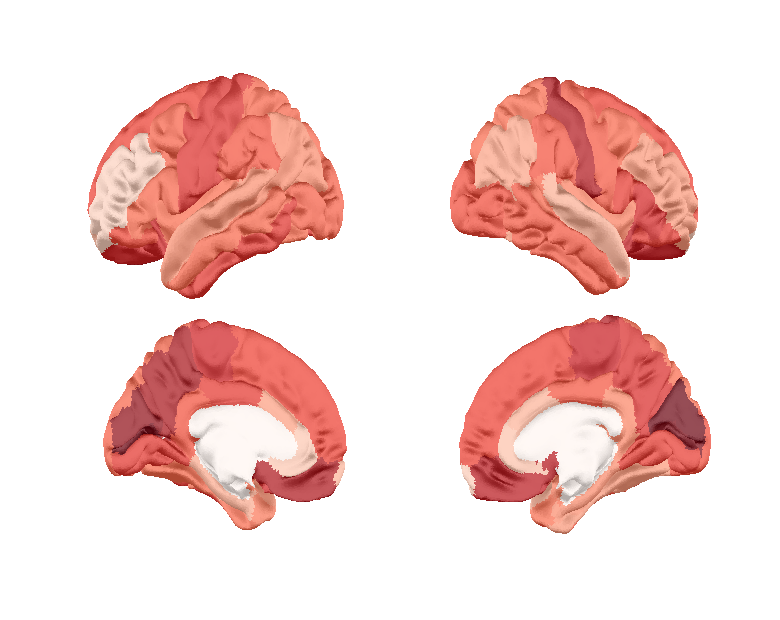

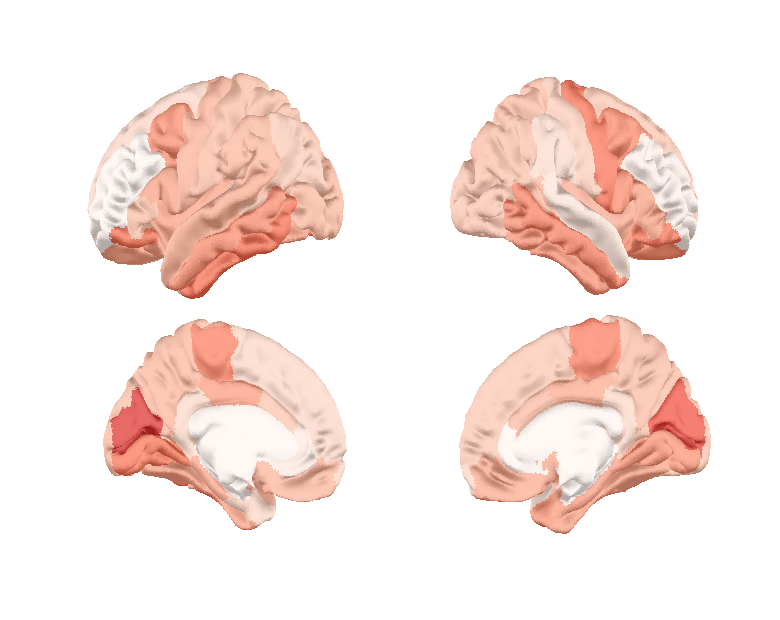

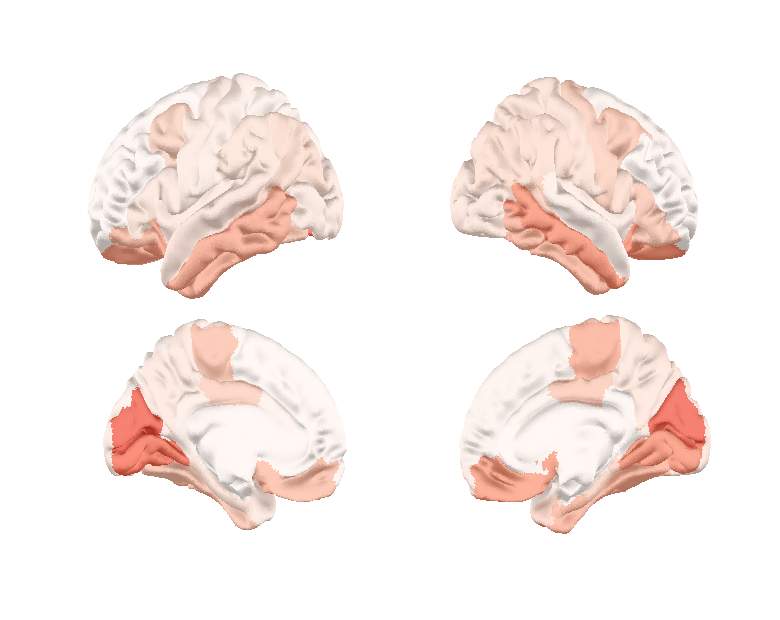

In [18]:

cmap = "Reds"
for band in paras.allbds:
    for meth in method_names: 
        vec = -np.log(band_res_pval[band][meth])
        vec[vec < vmin] = 0
        fig = _brain_plot(vec[order_idxs], cmap=cmap, vbds=[vmin, vmax]);
        fig.savefig(FIG_ROOT/f"revisionR1/rowwise_regr_{band}_{meth}_nlogpval.jpg")

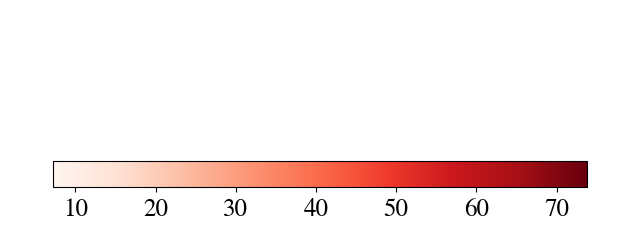

In [19]:
import matplotlib as mpl
cmap = "Reds"

fig, ax = plt.subplots(figsize=(8, 2))
plt.subplots_adjust(top=1)

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
ax.axis('off')

plt.savefig(FIG_ROOT/f"revisionR1/brain_metric_{cmap}_colorbar_nlogpval.jpg")